In [45]:
import os
import pickle
import json

import numpy as np
import matplotlib.pyplot as plt

# import rose packages
from rose.optimisation.optimisation import Optimisation, OptimisationModelPart, ModelResults
from SignalProcessing.signal_tools import Signal
from data_proc import ricardo, SoS


# Optimisation
Note that, to use this notebook, the notebook "rose_demo" has to be completed

# Read SoS

In [5]:
sos_dir = "../data/SoS"
sos = SoS.ReadSosScenarios(os.path.join(sos_dir, "soilprofiles.csv"),
                               os.path.join(sos_dir, "20201102_Prorail_parameters_SOS.csv"),
                               os.path.join(sos_dir, "segments.csv"),
                               os.path.join(sos_dir, "Segments_TKI_v2.shp"))
sos.create_segments()
sos.dump(os.path.join(sos_dir, "SOS.json"))

# Load SoS

In [6]:
with open(os.path.join(sos_dir, "SOS.json"), 'r') as f:
    sos_data = json.load(f)

# Read Ricardo data

In [7]:
ricardo_filenames = [r"../data/Ricardo/Jan.json",
             r"../data/Ricardo/Jun.json",
             ]
ricardo_output_fn = r"../data/Ricardo/inframon.pickle"
ricardo.read_inframon(ricardo_filenames, ricardo_output_fn)

{'Jan': {'time': array([0.000000e+00, 4.000000e-03, 8.000000e-03, ..., 3.929992e+03,
         3.929996e+03, 3.930000e+03]),
  'coordinates': array([[161519.2720761 , 383816.20233933],
         [161519.26484456, 383816.20322003],
         [161519.25761303, 383816.20410071],
         ...,
         [123020.82541223, 484367.9768349 ],
         [123020.82391575, 484367.98426241],
         [123020.82241927, 484367.99168992]]),
  'speed': array([1.931636  , 1.93704384, 1.94245168, ..., 1.74179859, 1.7283753 ,
         1.714952  ]),
  'acc_side_1': array([0.16322143, 0.10544159, 0.03208939, ..., 0.06827947, 0.06612804,
         0.07611204]),
  'acc_side_2': array([-0.31587233, -0.03515124,  0.01806325, ...,  0.02656312,
          0.02042447,  0.02461162]),
  'segment': array(['', '', '', ..., '', '', ''], dtype='<U12')},
 'Jun': {'time': array([0.000000e+00, 4.000000e-03, 8.000000e-03, ..., 3.938992e+03,
         3.938996e+03, 3.939000e+03]),
  'coordinates': array([[161514.0732546 , 383849.23

# Load Ricardo data

In [8]:
ricardo_data = ricardo.load_inframon_data(ricardo_output_fn)

# Get SoS Coordinates


In [46]:
# get coordinates of a segment
segment = sos_data["Segment 1030"]
coordinates = np.array(list(segment.values())[0]['coordinates'])

# get coordinate limits
xlim = [min(coordinates[:,0]), max(coordinates[:,0])]
ylim = [min(coordinates[:,1]), max(coordinates[:,1])]

# Get Ricardo data within SoS limits

In [47]:
ricardo_data_within_bounds = ricardo.get_data_within_bounds(ricardo_data["Jan"], xlim, ylim)

# Check if data is valid
The train velocity should be relatively constant over the bounded track, such that the acceleration signal is representative for a certain train speed at that point of the track

## check train velocity

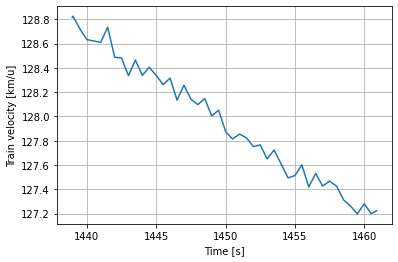

In [48]:
ricardo.plot_train_velocity(ricardo_data_within_bounds)
plt.grid()

## check acceleration signal

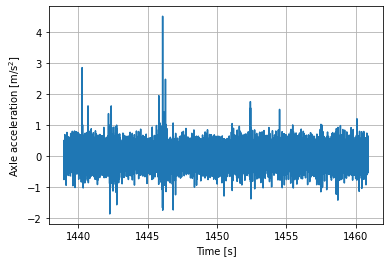

In [49]:
ricardo.plot_acceleration_signal(ricardo_data_within_bounds["time"], ricardo_data_within_bounds["acc_side_1"])
plt.grid()

# Filter inframon signal

In [73]:
# filter Ricardo measurements

# set filter settings
settings_filter = {"FS": 250,                   # acquisition frequency
                   "cut-off_high": 120,         # high cutoff frequency
                   "cut-off_low": 40,           # low cutoff frequency 
                   "n": 10,                     # order of the filter
                   "smoothing_distance": 10,    # distance of smoothed wavelength
                   }    

acceleration_data = ricardo_data_within_bounds["acc_side_1"]

# set ricardo signal
ricardo_signal = Signal(ricardo_data_within_bounds["time"],acceleration_data, settings_filter["FS"])


# filter high frequencies
ricardo_signal.filter(settings_filter["cut-off_high"], settings_filter["n"], type_filter="lowpass")

# filter low frequencies
ricardo_signal.filter(settings_filter["cut-off_low"], settings_filter["n"], type_filter="highpass")

# copy filtered signal
acc = np.copy(ricardo_signal.signal)


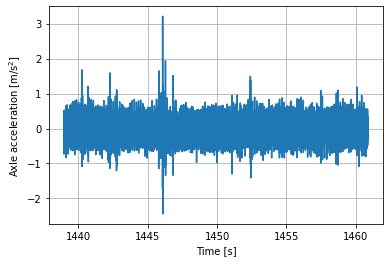

In [74]:
# plot filtered signal
ricardo.plot_acceleration_signal(ricardo_data_within_bounds["time"], acc)
plt.grid()

# Integrate acceleration signal to velocity signal



In [75]:
ricardo_signal.integrate(hp=True, moving=True, baseline=False, ini_cond=0)

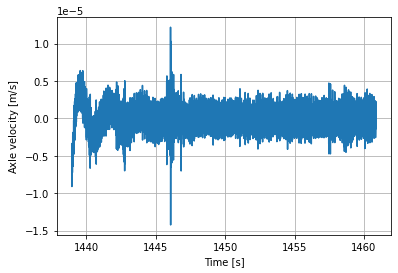

In [76]:
ricardo.plot_velocity_signal(ricardo_data_within_bounds["time"], ricardo_signal.signal)
plt.grid()

# Fast fourier transformation velocity signal

In [77]:
# fast fourier transformation of velocity signal

ricardo_signal.fft(half_representation=True)
freq_velocity = ricardo_signal.frequency
ampl_velocity = ricardo_signal.amplitude

# smooth signal
ampl_velocity = ricardo.smooth_signal_within_bounds_over_wave_length(ricardo_data_within_bounds, settings_filter["smoothing_distance"], ampl_velocity)

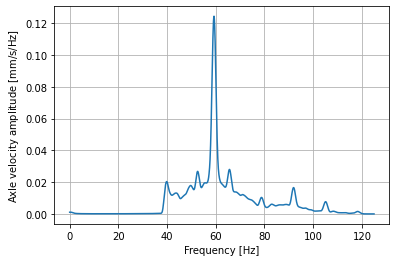

In [81]:
ricardo.plot_fft_velocity_signal(ricardo_data_within_bounds,acc, settings_filter["smoothing_distance"])
plt.grid()

In [82]:
# Get maximum velocity amplitude and corresponding frequency

m_to_mm = 1000

# maximum amplitude
max_vel_ampl = ampl_velocity[np.argmax(ampl_velocity)] * m_to_mm
# corresponding frequency
freq_at_max_vel = freq_velocity[np.argmax(ampl_velocity)]

In [83]:
max_vel_ampl, freq_at_max_vel 

(0.12437276722081402, 59.27647166028795)

# Check if frequency corresponds to the train speed
In this example, sleepers have a distance from eachother of 0.6 m. From the ricardo data, we can see that the average train speed over the segment is approximately 128 km/h. The frequency at the highest signal velocity should correspond to this train speed.

In [84]:
train_speed_mps = 128/3.6         # train speed in m/s
sleeper_dist = 0.6                # sleeper distance

load_frequency = train_speed_mps/sleeper_dist

In [85]:
load_frequency

59.25925925925927

# Update Rose model

In [86]:
# load results from rose demo

output_dir = "res"

with open(os.path.join(output_dir, "all_results.pickle"), 'rb') as f:
    coupled_model = pickle.load(f)["coupled_model"]

In [87]:
coupled_model.train.velocities

array([ 0.        ,  0.        ,  0.        , ..., 27.77777778,
       27.77777778, 27.77777778])

## reset velocities


In [34]:
# set velocity of train
velocities = np.ones(len(coupled_model.time)) * train_speed_mps

# prevent train from moving in initialisation phase
velocities[0:len(coupled_model.initialisation_time)] = 0
coupled_model.train.velocities = velocities

In [ ]:
# set more robust solver
from solvers.newmark_solver import NewmarkImplicitForce
solver = NewmarkImplicitForce()
coupled_model.solver = solver

# Set optimisation parameters

In [35]:
optimisation = Optimisation()
optimisation.model=coupled_model
optimisation.observations =[freq_at_max_vel, max_vel_ampl]


optimisation_model_part = OptimisationModelPart()
optimisation_model_part.model_part = coupled_model.track.model_parts[4] # soil

# set the parameter in the corresponding model part which should be optimised
optimisation_model_part.optimisation_parameter_names = ["stiffness"]

# Set model result settings

## create a function to perform a fast fourier transformation on rose output

In [36]:
def results_function(signal, aq_freq):
    """
    Results function to be performed after a coupled calculation
    
    This functoin takes a signal, performs a fast fourier transformation and returns 
    the maximum amplitude in the frequency domain and the corresponding frequency 

    :param signal: signal to be processed
    :param aq_freq: aquisition frequency
    :return:
    """
    from SignalProcessing.signal_tools import Signal
    import matplotlib.pyplot as plt
    
    # set signal
    sig = Signal(0,signal[:,0], aq_freq[0])
    
    # filter signal
    sig.filter(40, 6, type_filter="highpass")

    # fast fourier transformation
    sig.fft(half_representation=True)
    freq = sig.frequency
    ampl = sig.amplitude

    # get maximum amplitude and corresponding frequency
    max_ampl_idx = np.argmax(ampl)
    max_freq = freq[max_ampl_idx]
    max_ampl = ampl[max_ampl_idx]
    return max_freq, max_ampl

## the results to be transformed are the velocities in the front wheel of the train

In [37]:
coupled_model.velocities_out

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 2.82190060e-08,  9.59385028e-08,  2.17766093e-24, ...,
        -5.10341799e-03,  7.47570375e-03, -2.20667549e-03],
       [ 3.08278273e-08,  9.40805561e-08, -2.51799724e-23, ...,
        -5.12822682e-03,  7.43508257e-03, -2.38757260e-03],
       [ 3.33915750e-08,  9.20762633e-08, -5.25861559e-23, ...,
        -5.14299315e-03,  7.37862993e-03, -2.56122269e-03]])

## get the vertical displacement degree of freedom index of the front wheel of the train

In [38]:
result_index = coupled_model.train.wheels[-1].nodes[0].index_dof[1]

In [39]:
coupled_model.velocities_out[result_index,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [40]:
model_results = ModelResults()

# set name of result attribute as present in the coupled model
model_results.result_names = ["velocities_out"]
# set the index of the result to be used
model_results.result_indices = [result_index]
# set the timesteps to be used for the optimisation
model_results.time_step_indices = np.arange(int(len(coupled_model.initialisation_time)),int(len(coupled_model.time)))
# set result function
model_results.result_function = results_function

In [41]:
# calculate aquisition frequency
dt = np.diff(coupled_model.time)[-1]

aq_freq = 1/dt

# set model results arguments
model_results.args =[aq_freq]

## Initialise optimisation algorithm
The optimisation algorithm which is used is the levenberg marquart algorithm. Which is a gradient based algorithm which works efficiently when only a few parameters are to be optimised and the problem is not highly non-linear.

In [42]:
optimisation.model_results = [model_results]
optimisation.optimisation_model_parts = [optimisation_model_part]
optimisation.initialise()

## perform optimisation

In [43]:
initial_guess_stiffness = 5e7

In [44]:
optimisation.least_square(np.array([initial_guess_stiffness]), ftol=1e-8)

.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                                                           |  | |\|| //_\ | |_/
 | _ ) _  _ (_)     

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 2.00ksteps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 1.00ksteps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.70ksteps/s]
  5%|████████▊                                                                                                                                                                                  | 376/8.00k [00:00<00:04, 1.88ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.74ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 667steps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:03<00:00, 1.64ksteps/s]
  2%|████                                                                                                                                                                                       | 176/8.00k [00:00<00:04, 1.76ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.74ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 666steps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<?, ?steps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.68ksteps/s]
  5%|████████▌                                                                                                                                                                                  | 366/8.00k [00:00<00:04, 1.82ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.76ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 1.00ksteps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<?, ?steps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.74ksteps/s]
  5%|████████▋                                                                                                                                                                                  | 374/8.00k [00:00<00:04, 1.85ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.79ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 977steps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 1.04ksteps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.70ksteps/s]
  0%|                                                                                                                                                                                                  | 0.00/8.00k [00:00<?, ?steps/s]..\rose\model\train_track_interaction.py:189: RuntimeWarning: invalid value encountered in power
  np.nan_to_num(np.power(1 / self.hertzian_contact_coef * (elastic_wheel_deformation - du_wheels)
  1%|██                                                                                                                                                                                          | 86.0/8.00k [00:00<00:14, 564steps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.74ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 666steps/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 994steps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.71ksteps/s]
  5%|████████▊                                                                                                                                                                                  | 377/8.00k [00:00<00:04, 1.87ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.77ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 673steps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 1.00ksteps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.73ksteps/s]
  5%|████████▋                                                                                                                                                                                  | 370/8.00k [00:00<00:04, 1.84ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.73ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 665steps/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 998steps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.68ksteps/s]
  5%|████████▌                                                                                                                                                                                  | 367/8.00k [00:00<00:04, 1.83ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.75ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 499steps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 1.00ksteps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.67ksteps/s]
  2%|████▎                                                                                                                                                                                      | 184/8.00k [00:00<00:04, 1.84ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.73ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 674steps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 1.00ksteps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.75ksteps/s]
  2%|████▍                                                                                                                                                                                      | 190/8.00k [00:00<00:04, 1.88ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.78ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 666steps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 1.03ksteps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.73ksteps/s]
  2%|████▎                                                                                                                                                                                      | 185/8.00k [00:00<00:04, 1.85ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.75ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 666steps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 1.00ksteps/s]

Initial static displacement of the train and the track
Calculating calculation phase



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.74ksteps/s]
  5%|████████▋                                                                                                                                                                                  | 372/8.00k [00:00<00:04, 1.85ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.74ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 999steps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<?, ?steps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:03<00:00, 1.64ksteps/s]
  4%|███████▉                                                                                                                                                                                   | 337/8.00k [00:00<00:04, 1.68ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.71ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 495steps/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 969steps/s]

Initial static displacement of the train and the track
Calculating calculation phase



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.74ksteps/s]
  2%|████▎                                                                                                                                                                                      | 185/8.00k [00:00<00:04, 1.85ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.77ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 505steps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<?, ?steps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.71ksteps/s]
  2%|████▎                                                                                                                                                                                      | 185/8.00k [00:00<00:04, 1.83ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.75ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 999steps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<?, ?steps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.72ksteps/s]
  5%|████████▌                                                                                                                                                                                  | 366/8.00k [00:00<00:04, 1.84ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.70ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 399steps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 1.03ksteps/s]

Initial static displacement of the train and the track
Calculating calculation phase



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.74ksteps/s]
  2%|████▎                                                                                                                                                                                      | 182/8.00k [00:00<00:04, 1.80ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.74ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 669steps/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 999steps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.67ksteps/s]
  2%|████▍                                                                                                                                                                                      | 190/8.00k [00:00<00:04, 1.90ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.77ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 400steps/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 966steps/s]

Initial static displacement of the train and the track
Calculating calculation phase



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.69ksteps/s]
  2%|███▊                                                                                                                                                                                       | 162/8.00k [00:00<00:04, 1.62ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.70ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 500steps/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 996steps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.73ksteps/s]
  5%|████████▋                                                                                                                                                                                  | 373/8.00k [00:00<00:04, 1.88ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.73ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 500steps/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 998steps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.73ksteps/s]
  2%|████▌                                                                                                                                                                                      | 194/8.00k [00:00<00:04, 1.94ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.79ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 182steps/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 250steps/s]

Initial static displacement of the train and the track



  3%|██████▎                                                                                                                                                                                    | 170/5.00k [00:00<00:02, 1.68ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:03<00:00, 1.66ksteps/s]
  2%|████▏                                                                                                                                                                                      | 179/8.00k [00:00<00:04, 1.79ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.69ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 674steps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 1.04ksteps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.72ksteps/s]
  4%|████████▎                                                                                                                                                                                  | 358/8.00k [00:00<00:04, 1.81ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.73ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 223steps/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 500steps/s]

Initial static displacement of the train and the track
Calculating calculation phase



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.70ksteps/s]
  2%|████▍                                                                                                                                                                                      | 191/8.00k [00:00<00:04, 1.89ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.76ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 400steps/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 493steps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.72ksteps/s]
  5%|████████▊                                                                                                                                                                                  | 377/8.00k [00:00<00:04, 1.89ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.78ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 499steps/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 501steps/s]

Initial static displacement of the train and the track



  7%|█████████████▉                                                                                                                                                                             | 371/5.00k [00:00<00:02, 1.84ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.71ksteps/s]
  2%|████▎                                                                                                                                                                                      | 187/8.00k [00:00<00:04, 1.84ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.77ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 335steps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.73ksteps/s]
  5%|████████▋                                                                                                                                                                                  | 370/8.00k [00:00<00:04, 1.84ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.75ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
.______        ______        _______. _______
|   _  \      /  __  \      /       ||   ____|                                                                                                       __
|  |_)  |    |  |  |  |    |   (----`|  |__                                                                                                   ___  _// \
|      /     |  |  |  |     \   \    |   __|                                                                                                _/   \/__|_ \
|  |\  \----.|  `--'  | .----)   |   |  |____                                                                                              /  __//_/==\_| ___
| _| `._____| \______/  |_______/    |_______|                                                                                           / | / /|// == \ \   /
  ___        _                                                                                

Initialising model parts
Initialising global matrices
Initialising global matrices
Initialising track wheel interaction


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.00/2.00 [00:00<00:00, 400steps/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00/1.00 [00:00<00:00, 1.06ksteps/s]
  0%|                                                                                                                                                                                                  | 0.00/5.00k [00:00<?, ?steps/s]

Initial static displacement of the train and the track
Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5.00k/5.00k [00:02<00:00, 1.72ksteps/s]
  2%|████▍                                                                                                                                                                                      | 191/8.00k [00:00<00:04, 1.91ksteps/s]

Calculating calculation phase


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8.00k/8.00k [00:04<00:00, 1.76ksteps/s]


Finalising calculation



  Your focus determines your reality. 
--- Qui - Gon Jinn
